In [55]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D,\
                                    LeakyReLU, BatchNormalization, Activation,\
                                    Dropout, Concatenate, Lambda, Reshape

In [5]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def define_generator(input_shape):
    """This is a resnet50_unet"""

    """ Input """
    inputs = Input(input_shape)
    grayscale_input = Lambda(lambda x: x[..., 0][..., tf.newaxis], input_shape=input_shape)(inputs)
    grayscale_resnet_input = Concatenate()([grayscale_input, grayscale_input, grayscale_input])

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=grayscale_resnet_input)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (256 x 256)
    s2 = resnet50.get_layer("conv1_relu").output        ## (128 x 128)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (64 x 64)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (32 x 32)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (16 x 16)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (32 x 32)
    d2 = decoder_block(d1, s3, 256)                     ## (64 x 64)
    d3 = decoder_block(d2, s2, 128)                     ## (128 x 128)
    d4 = decoder_block(d3, s1, 64)                      ## (256 x 256)

    """ Output """
    outputs = Conv2D(2, (1, 1), padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

tf.keras.backend.clear_session()
input_shape = (256, 256, 1)
model = define_generator(input_shape)

2022-11-16 16:41:22.991817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 16:41:22.993545: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 5s 0us/step


In [6]:
model.load_weights('weights/generator_epoch10_0.0344.h5')

In [33]:
def custom_generator(data_generator):
    n = data_generator.samples
    batch_size = data_generator.batch_size
    end_index = n - n % batch_size
    while True:
        batch = data_generator.next()
        L_batch = batch[..., 0][..., np.newaxis]
        yield L_batch

def preprocessing(image):
    image = np.array(image, dtype=np.uint8)
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB) / 255
    return lab_image

datagen = ImageDataGenerator(
    preprocessing_function = preprocessing
    )

frames_data = datagen.flow_from_directory("/home/arno/Workspace/itc/projects/DeepColor/videos/", class_mode=None, target_size=(256, 256), batch_size=32, shuffle=False)

Found 308 images belonging to 1 classes.


In [75]:
colored_frames = []
for i, grayscale_batch in enumerate(tqdm(custom_generator(frames_data), total=len(frames_data))):
    if i == len(frames_data):
        break
    ab_batch = model.predict(grayscale_batch)
    Lab_batch = np.concatenate((grayscale_batch, ab_batch), axis=-1)
    Lab_batch = (Lab_batch * 255).astype(np.uint8)
    for Lab_frame in Lab_batch: 
        rgb = cv2.cvtColor(Lab_frame, cv2.COLOR_LAB2RGB)
        colored_frames.append(rgb)

100%|███████████████████████████████████████████| 10/10 [02:25<00:00, 14.58s/it]


In [83]:
def create_video_from_frame_array(frames, output_dir, frameSize=(854//2, 480//2)):
    write_path = os.path.join(output_dir, "output_video.avi")
    out = cv2.VideoWriter(write_path, cv2.VideoWriter_fourcc(*'DIVX'), 25, frameSize)
    for frame in tqdm(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        frame = cv2.resize(frame, frameSize, cv2.INTER_CUBIC)
        out.write(frame)
    out.release()

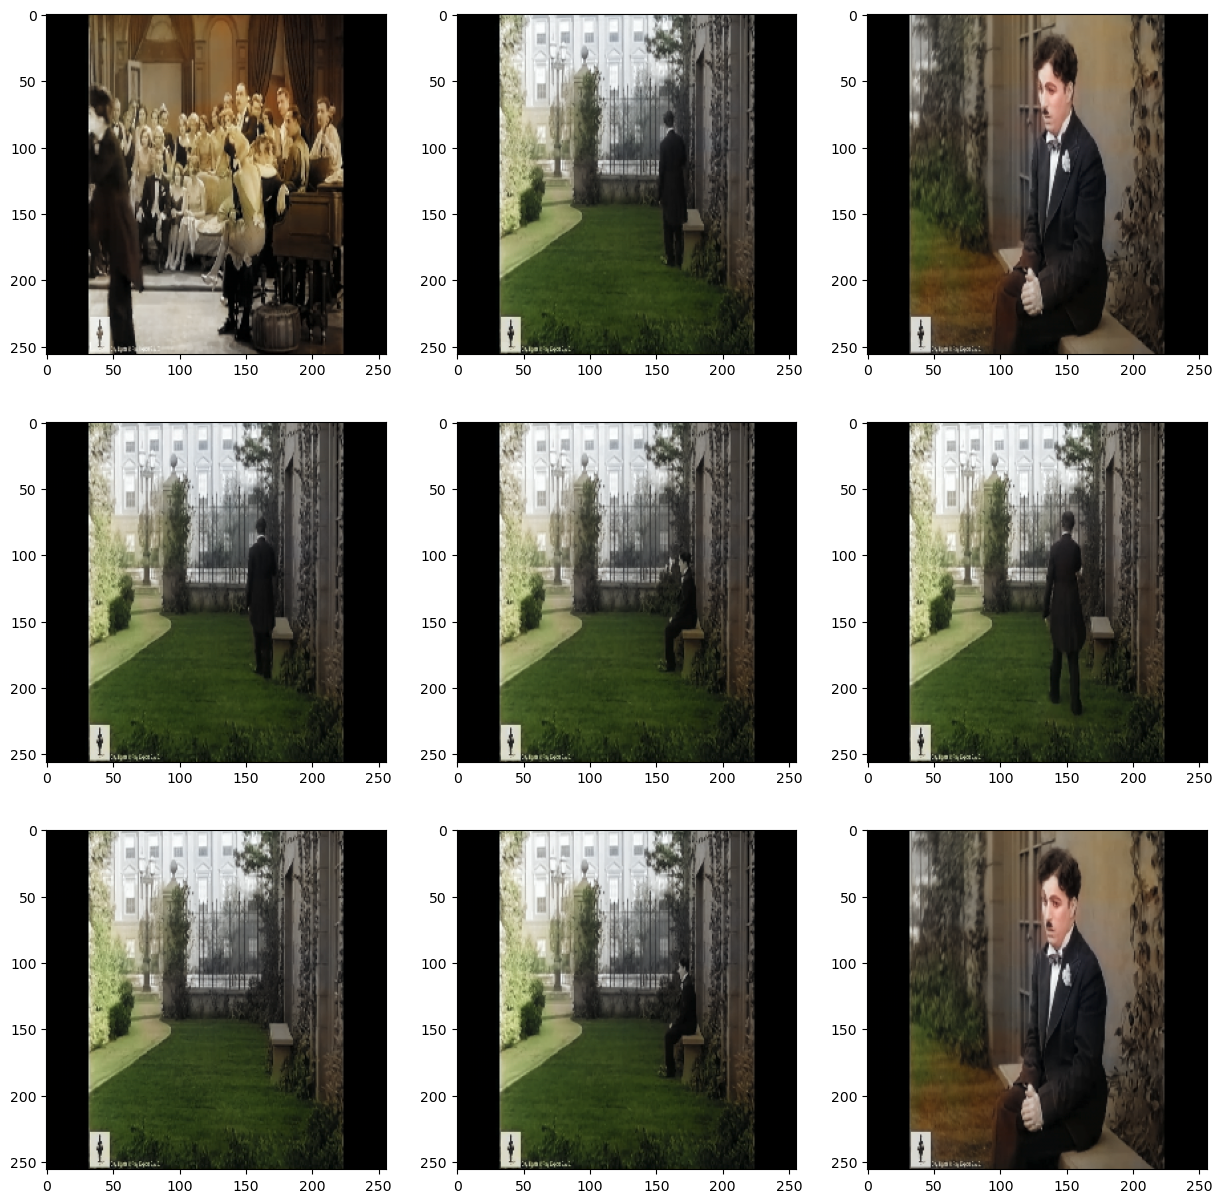

In [84]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(9):
    ax = axes.flat[i]
    ax.imshow(random.sample(colored_frames, 1)[0])

In [85]:
create_video_from_frame_array(colored_frames, 'videos/')

100%|████████████████████████████████████████| 340/340 [00:00<00:00, 864.12it/s]
